In [3]:
#Importing modules
import os
import pandas as pd
import numpy as np
import pyreadr


Loading the files:

In [4]:
data_path = "/Users/polinaziboreva/Desktop/SPECIALE/Datasets(Article)"
files_external_C = ["DEMO_C.XPT", "OCQ_C.XPT", "HSQ_C.XPT"] 

data_path_r = "/Users/polinaziboreva/Desktop/SPECIALE/Datasets(Article)/rnhanesdata"
files_fromPackage = ["Covariate_C.rda", "Flags_C.rda", "PAXINTEN_C.rda", "Mortality_2015_C.rda", "Mortality_2011_C.rda"] 

In [5]:
def rdaOpener(data_path, filename):
    file = os.path.join(data_path, filename)
    data = pyreadr.read_r(file)
    return data

Files from cdc.gov:

In [6]:
df_demo_c = pd.read_sas((data_path + "/DEMO_C.XPT"), format = "xport")
df_ocq_c = pd.read_sas((data_path + "/OCQ_C.XPT"), format = "xport")
df_hsq_c = pd.read_sas((data_path + "/HSQ_C.XPT"), format = "xport")
df_demo_d = pd.read_sas((data_path + "/DEMO_D.XPT"), format = "xport")
df_ocq_d = pd.read_sas((data_path + "/OCQ_D.XPT"), format = "xport")
df_hsq_d = pd.read_sas((data_path + "/HSQ_D.XPT"), format = "xport")

/var/folders/79/l1ssq98x45g28xjlwbwghmy80000gn/T/ipykernel_6001/1581770724.py:5: UserWarning: xport file may be corrupted.
  df_ocq_d = pd.read_sas((data_path + "/OCQ_D.XPT"), format = "xport")


Files from Github: https://github.com/andrew-leroux/rnhanesdata

In [7]:
df_paxraw_rda_C = rdaOpener(data_path_r, "PAXINTEN_C.rda")
df_flags_rda_C = rdaOpener(data_path_r, "Flags_C.rda")
df_covariate_rda_C = rdaOpener(data_path_r, "Covariate_C.rda")
df_mort15_rda_C = rdaOpener(data_path_r, "Mortality_2015_C.rda")
df_paxraw_rda_D = rdaOpener(data_path_r, "PAXINTEN_D.rda")
df_flags_rda_D = rdaOpener(data_path_r, "Flags_D.rda")
df_covariate_rda_D = rdaOpener(data_path_r, "Covariate_D.rda")
df_mort15_rda_D = rdaOpener(data_path_r, "Mortality_2015_D.rda")

In [8]:
df_paxraw_rda_C = list(df_paxraw_rda_C.values())[0] if df_paxraw_rda_C else None
df_flags_rda_C = list(df_flags_rda_C.values())[0] if df_flags_rda_C else None
df_covariate_rda_C = list(df_covariate_rda_C.values())[0] if df_covariate_rda_C else None
df_mort15_rda_C = list(df_mort15_rda_C.values())[0] if df_mort15_rda_C else None
df_paxraw_rda_D = list(df_paxraw_rda_D.values())[0] if df_paxraw_rda_D else None
df_flags_rda_D = list(df_flags_rda_D.values())[0] if df_flags_rda_D else None
df_covariate_rda_D = list(df_covariate_rda_D.values())[0] if df_covariate_rda_D else None
df_mort15_rda_D = list(df_mort15_rda_D.values())[0] if df_mort15_rda_D else None

In [9]:
vars_interest = ["INDFMPIR", "HSD010", "HSQ480", "OCD150", "OCQ180", "OCQ210", "OCQ380"]

Demo_Cz = df_demo_c[["SEQN"] + [var for var in vars_interest if var in df_demo_c.columns]]
hSQ_Cz = df_hsq_c[["SEQN"] + [var for var in vars_interest if var in df_hsq_c.columns]]
oCQ_Cz = df_ocq_c[["SEQN"] + [var for var in vars_interest if var in df_ocq_c.columns]]
Demo_Dz = df_demo_d[["SEQN"] + [var for var in vars_interest if var in df_demo_d.columns]]
hSQ_Dz = df_hsq_d[["SEQN"] + [var for var in vars_interest if var in df_hsq_d.columns]]
oCQ_Dz = df_ocq_d[["SEQN"] + [var for var in vars_interest if var in df_ocq_d.columns]]

Covar_C = Demo_Cz.merge(hSQ_Cz, on="SEQN", how="left").merge(oCQ_Cz, on="SEQN", how="left")
Covar_D = Demo_Dz.merge(hSQ_Dz, on="SEQN", how="left").merge(oCQ_Dz, on="SEQN", how="left")

df_covariate_rda_C = df_covariate_rda_C.merge(Covar_C, on="SEQN", how="left")
df_covariate_rda_D = df_covariate_rda_D.merge(Covar_D, on="SEQN", how="left")

Section 1b: Prep accelerometry data for analysis and merge all data 

In [10]:
# Re-code activity counts which are considered "non-wear" to be 0.
for i in range(1, 1441):  
    col_name = f"MIN{i}"
    df_paxraw_rda_C[col_name] = df_paxraw_rda_C[col_name] * df_flags_rda_C[col_name]

for i in range(1, 1441):  
    col_name = f"MIN{i}"
    df_paxraw_rda_D[col_name] = df_paxraw_rda_D[col_name] * df_flags_rda_D[col_name]


In [11]:
#Merging all files from wave C (2003-2004)
data_C = (
    df_paxraw_rda_C
    .merge(df_mort15_rda_C, on="SEQN", how="left")
    .merge(df_covariate_rda_C, on=["SEQN", "SDDSRVYR"], how="left")
    .merge(df_flags_rda_C,
            on=["SEQN", "PAXCAL", "PAXSTAT", "WEEKDAY", "SDDSRVYR"],
            how="left",
            suffixes=(".AC", ".Flag")
    )
)

#Merging all files from wave D (2005-2006)
data_D = (
    df_paxraw_rda_D
    .merge(df_mort15_rda_D, on="SEQN", how="left")
    .merge(df_covariate_rda_D, on=["SEQN", "SDDSRVYR"], how="left")
    .merge(df_flags_rda_D,
            on=["SEQN", "PAXCAL", "PAXSTAT", "WEEKDAY", "SDDSRVYR"],
            how="left",
            suffixes=(".AC", ".Flag")
    )
)

In [12]:
# Joining 2 waves together 
data = pd.concat([data_C, data_D], ignore_index=True)

In [13]:
#Summing amount of wear time per day:
data["wear_time"] = data.filter(like=".Flag").sum(axis=1, skipna=True)

#Good day if the wear time was equal or more than 10 hours (600 minutess) + calibration and quality flags = 1
data["good_day"] = ((data["wear_time"] >= 600) & (data["PAXCAL"] == 1) & (data["PAXSTAT"] == 1)).astype(int)

#Amount of good days per SEQN
data["n_good_days"] = data.groupby("SEQN")["good_day"].transform("sum")

# Dropping Flag columns
data = data.drop(columns=[col for col in data.columns if col.endswith(".Flag")])
data = data.rename(columns={col: col.replace(".AC", "") for col in data.columns if col.endswith(".AC")})

Section 1c: create new variables/relevel factor variables for analyses

In [14]:
#Age in years
data["Age"] = data["RIDAGEEX"] / 12

#Age "Group"
data["Age_cat"] = pd.cut(data["Age"], bins=[0, 1, 3, 6, 12, 16, 20, 30, 40, 50, 60, 70, 80, 85], right=False)
data["DoW"] = data["WEEKDAY"].map({1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"})
data["Overall_health"] = data["HSD010"].map({1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"})
data["n_bad_mental_days"] = data["HSQ480"].replace({77: None, 99: None})
data["PIR"] = pd.cut(data["INDFMPIR"], bins=[0, 1, 2.5, float("inf")], right=False)
data["Employed"] = data.apply(
    lambda row: "Employed: full time"   if row["OCD150"] == 1      and row["OCQ180"] >= 35 else 
                "Employed: part time"   if row["OCD150"] == 1      and row["OCQ180"] < 35 else 
                "Unemployed: healthy"   if row["OCD150"] in [3, 4] and row["OCQ380"] in [1, 2, 3, 5, 7] else 
                "Unemployed: unhealthy" if row["OCD150"] in [3, 4] and row["OCQ380"] in [4, 6] else None, axis=1)
data["Employed"] = pd.Categorical(data["Employed"], categories=["Employed: full time", "Employed: part time", "Unemployed: healthy", "Unemployed: unhealthy"])
data["Education"] = data["EducationAdult"].replace({"Less than 9th grade": "Less than high school", "9-11th grade": "Less than high school", "High school grad/GED or equivalent": "High school", "Some College or AA degree": "More than high school", "College graduate or above": "More than high school"})
data["CHD"] = data["CHD"].replace({"No": "No", "Refused": "No", "Don't Know": "No", "Yes": "Yes"})
data["CHF"] = data["CHF"].replace({"No": "No", "Refused": "No", "Don't Know": "No", "Yes": "Yes"})
data["Stroke"] = data["Stroke"].replace({"No": "No", "Refused": "No", "Don't Know": "No", "Yes": "Yes"})
data["Cancer"] = data["Cancer"].replace({"No": "No", "Refused": "No", "Don't Know": "No", "Yes": "Yes"})
data["Diabetes"] = data["Diabetes"].replace({"No": "No", "Borderline": "No", "Refused": "No", "Don't Know": "No", "Yes": "Yes"})
data["Alcohol"] = data["DrinkStatus"].astype("category").cat.add_categories("Missing alcohol").fillna("Missing alcohol")
data["time_mort"] = data["permth_exm"] / 12
data["event"] = data["mortstat"]

/var/folders/79/l1ssq98x45g28xjlwbwghmy80000gn/T/ipykernel_6001/512202280.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data["Education"] = data["EducationAdult"].replace({"Less than 9th grade": "Less than high school", "9-11th grade": "Less than high school", "High school grad/GED or equivalent": "High school", "Some College or AA degree": "More than high school", "College graduate or above": "More than high school"})
/var/folders/79/l1ssq98x45g28xjlwbwghmy80000gn/T/ipykernel_6001/512202280.py:21: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data["Diabete

In [15]:
activity_cols = [col for col in data.columns if col.startswith("MIN")]
data = data[[col for col in data.columns if col not in activity_cols] + activity_cols]

In [16]:
vars_interest = [
    "time_mort", "event", "Age", "BMI_cat", "Employed", "Education", "PIR", "Overall_health", 
    "CHD", "CHF", "Stroke", "Cancer", "Diabetes", "SmokeCigs", "Alcohol"
]

In [17]:
print("SEQN:", data['SEQN'].nunique())

SEQN: 14631


In [ ]:
data["Exclude_age"] = ((data["Age"] < 50) | (data["Age"] >= 85) | data["Age"].isna()).astype(int)
data = data[data["Exclude_age"] == 0]
print("SEQN After excluding age:", data['SEQN'].nunique())
data["Exclude_accel"] = ((data["n_good_days"] < 3)).astype(int)
data = data[data["Exclude_accel"] == 0]
print("SEQN After excluding small number of good days:", data['SEQN'].nunique())
data["Exclude_na"] = data[vars_interest].isna().any(axis=1).astype(int)
data = data[data["Exclude_na"] == 0]
print("SEQN After excluding NA values:", data['SEQN'].nunique())


SEQN After excluding age: 3772
SEQN After excluding small number of good days: 3255
SEQN After excluding NA values: 2830


In [20]:
#censoring participants who died due to accidents
data.loc[data["ucod_leading"] == "004", "mortstat"] = 0

In [21]:
#Saving the data
data.to_csv("data.csv", index=False)

Figures:

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
path = "/Users/polinaziboreva/Desktop/SPECIALE/"

save_figure_path = os.path.join(path, "figures") 
save_data_path = os.path.join(path, "data") 

csv_file = os.path.join(path, "data.csv")
data_analysis = pd.read_csv(csv_file)

In [24]:
data_analysis = data
act_mat_full = data_analysis.loc[:, "MIN1":"MIN1440"].to_numpy(dtype=float)

act_log_mat_full = np.log(1+act_mat_full)
act_sqrt_mat_full = np.sqrt(act_mat_full) 


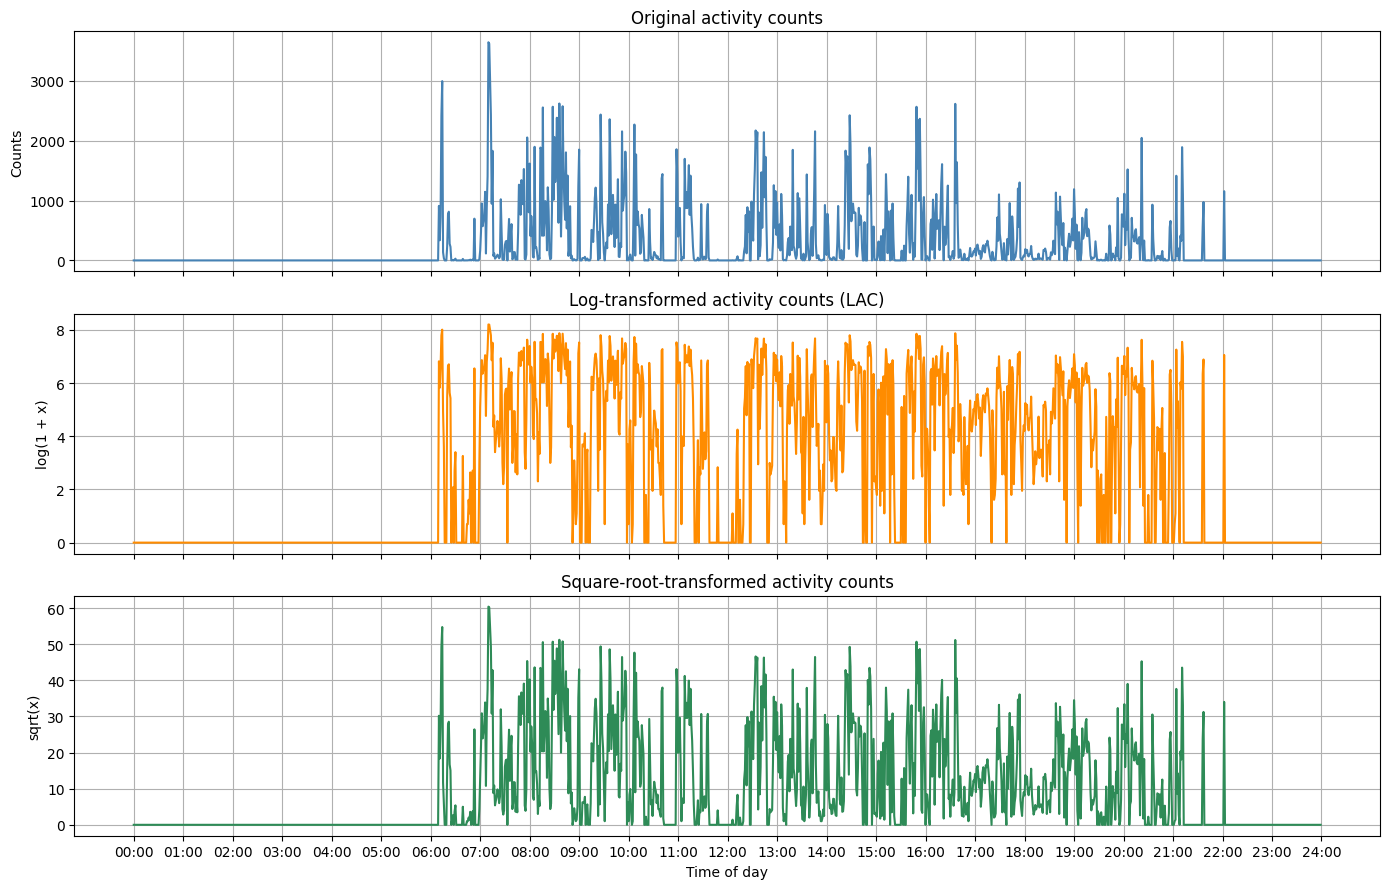

In [25]:
i = 0

original_row = act_mat_full[i]
log_row = act_log_mat_full[i]
sqrt_row = act_sqrt_mat_full[i]

minutes = np.arange(1440)

hour_ticks = np.arange(0, 1441, 60)
hour_labels = [f"{h:02}:00" for h in range(25)]  # 00:00 to 24:00

# Create the figure
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# Original
axs[0].plot(minutes, original_row, color='steelblue')
axs[0].set_title("Original activity counts")
axs[0].set_ylabel("Counts")
axs[0].grid(True)

# Log-transformed
axs[1].plot(minutes, log_row, color='darkorange')
axs[1].set_title("Log-transformed activity counts (LAC)")
axs[1].set_ylabel("log(1 + x)")
axs[1].grid(True)

# Square-root-transformed
axs[2].plot(minutes, sqrt_row, color='seagreen')
axs[2].set_title("Square-root-transformed activity counts")
axs[2].set_ylabel("sqrt(x)")
axs[2].set_xlabel("Time of day")
axs[2].grid(True)
axs[2].set_xticks(hour_ticks)
axs[2].set_xticklabels(hour_labels)

plt.tight_layout()
plt.show()


In [26]:
grouped = data_analysis.groupby("SEQN").indices

act_mat = np.vstack([np.nanmean(act_mat_full[idx, :], axis=0) for idx in grouped.values()])
act_log_mat = np.vstack([np.nanmean(act_log_mat_full[idx, :], axis=0) for idx in grouped.values()])
act_sqrt_mat = np.vstack([np.nanmean(act_sqrt_mat_full[idx, :], axis=0) for idx in grouped.values()])

data_analysis = data_analysis.loc[~data_analysis.duplicated("SEQN"), :].drop(columns=[col for col in data_analysis.columns if col.startswith("MIN")])
data_analysis = data_analysis.drop(columns=["WEEKDAY", "good_day"] + [col for col in data_analysis.columns if col.startswith("Exclude")])

censor_mort = data_analysis['time_mort'] > 10
data_analysis.loc[censor_mort, 'event'] = 0
data_analysis.loc[censor_mort, 'time_mort'] = 10

In [27]:
participant_index = 0
start = participant_index * 7
end = start + 7

log_transformed_days = act_log_mat_full[start:end]

average_log_curve = act_log_mat[participant_index]

minutes = np.arange(1440)

/var/folders/79/l1ssq98x45g28xjlwbwghmy80000gn/T/ipykernel_6001/3048577040.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


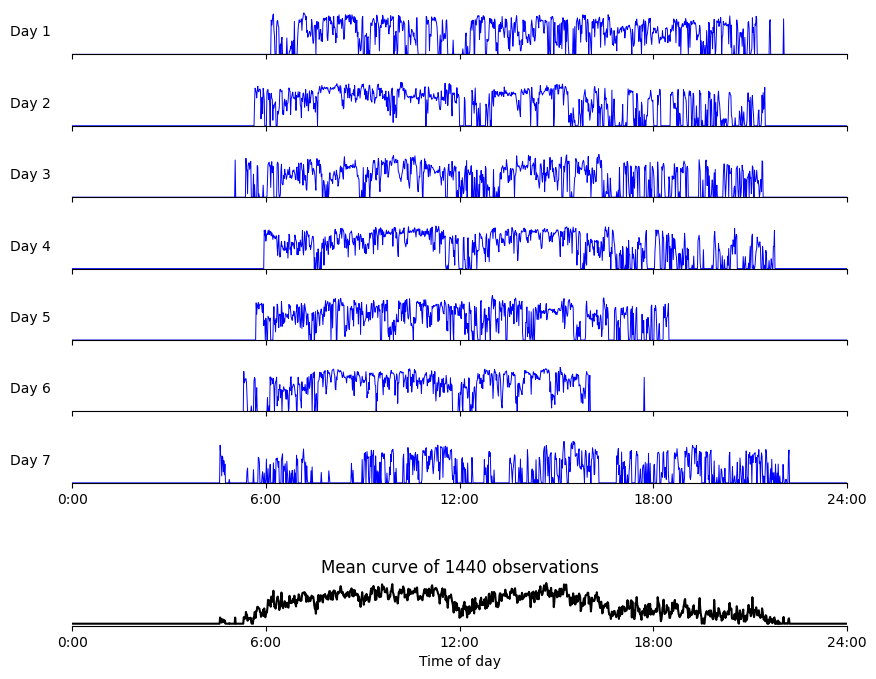

In [28]:
days = log_transformed_days.shape[0]
minutes = np.arange(1440)
hours = np.arange(0, 25, 6)
minute_ticks = hours * 60
time_labels = [f"{h}:00" for h in hours]

fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(nrows=9, hspace=0.6)
axes = [fig.add_subplot(gs[i]) for i in range(7)]
mean_ax = fig.add_subplot(gs[8])

for i in range(7):
    axes[i].plot(minutes, log_transformed_days[i], color='blue', linewidth=0.7)
    axes[i].set_xlim(0, 1440)
    axes[i].set_ylim(log_transformed_days.min(), log_transformed_days.max())
    axes[i].set_xticks(minute_ticks)
    axes[i].set_xticklabels([] if i < 6 else time_labels)
    axes[i].set_yticks([])
    axes[i].set_ylabel(f"Day {i+1}", rotation=0, labelpad=30, va='center')
    axes[i].spines[['top', 'right', 'left']].set_visible(False)

# Mean curve
mean_ax.plot(minutes, average_log_curve, color='black')
mean_ax.set_xlim(0, 1440)
mean_ax.set_xticks(minute_ticks)
mean_ax.set_xticklabels(time_labels)
mean_ax.set_yticks([])
mean_ax.set_xlabel("Time of day")
mean_ax.set_title("Mean curve of 1440 observations", fontsize=12)
mean_ax.spines[['top', 'right', 'left']].set_visible(False)

plt.tight_layout()
plt.show()


In [29]:
data_analysis['Age'] = data_analysis['Age'].round().astype(int)

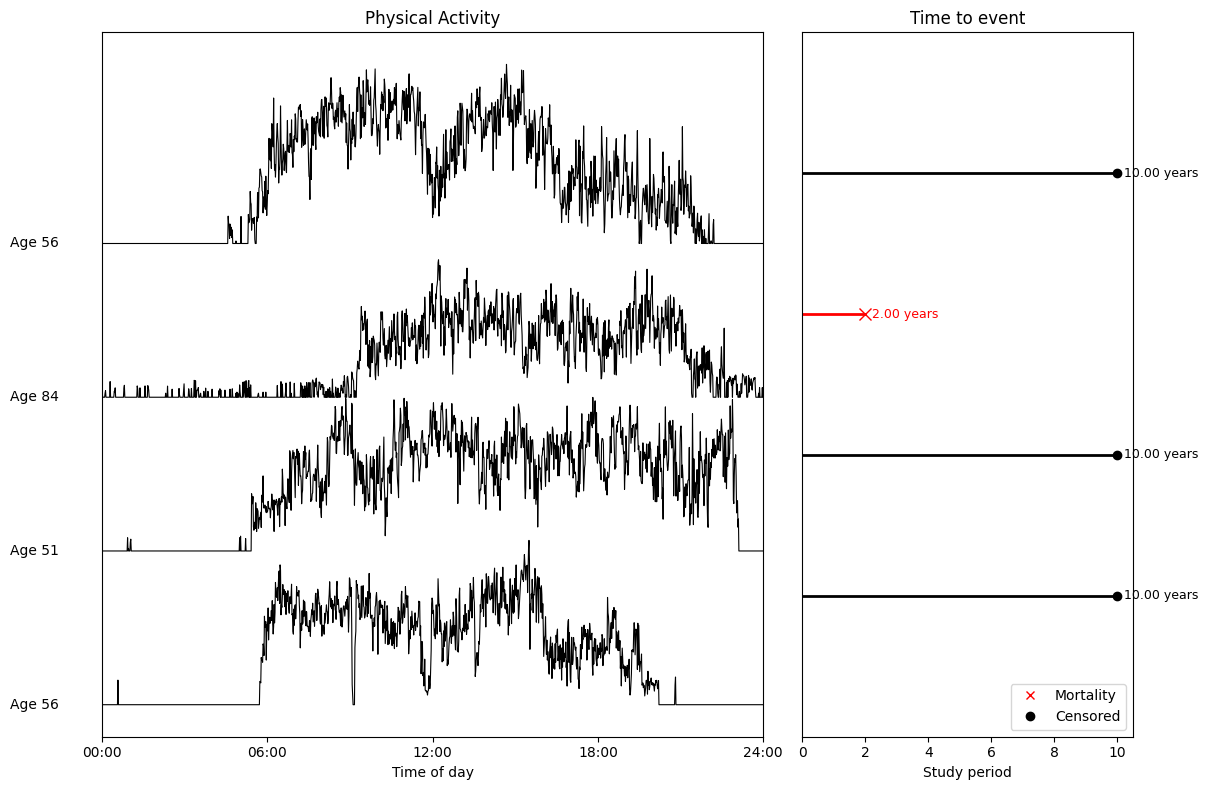

In [30]:
n_participants = 4

start_diff = 0 
end_diff = start_diff + n_participants

log_days_n_participants = act_log_mat[start_diff:end_diff]

ages = data_analysis['Age'][:4].values
times = data_analysis['time_mort'][:4].values
events = data_analysis['event'][:4].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]})

spacing = 6  

for i in range(n_participants):
    offset = n_participants - i 
    ax1.plot(minutes, log_days_n_participants[i] + offset * spacing, color='black', linewidth=0.8)
    ax1.text(-200, offset * spacing, f"Age {ages[i]}", va='center', fontsize=10)

ax1.set_xlim(0, 1440)
ax1.set_xticks([0, 360, 720, 1080, 1440])
ax1.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'])
ax1.set_yticks([])
ax1.set_xlabel("Time of day")
ax1.set_title("Physical Activity")

for i in range(n_participants):
    y = (n_participants - i) * spacing  
    color = 'red' if events[i] == 1 else 'black'

    ax2.hlines(y, 0, times[i], color=color, linewidth=2)
    if events[i] == 1:
        ax2.plot(times[i], y, 'x', color='red', markersize=8)
        ax2.text(times[i] + 0.2, y, f"{times[i]:.2f} years", va='center', color='red', fontsize=9)
    else:
        ax2.plot(times[i], y, 'o', color='black', markersize=6)
        ax2.text(times[i] + 0.2, y, f"{times[i]:.2f} years", va='center', color='black', fontsize=9)

ax2.set_ylim(0, (n_participants + 1) * spacing)
ax2.set_xlim(0, 10.5)
ax2.set_xlabel("Study period")
ax2.set_yticks([])
ax2.set_title("Time to event")

ax2.plot([], [], 'x', color='red', label='Mortality')
ax2.plot([], [], 'o', color='black', label='Censored')
ax2.legend(loc='lower right')

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()
